In [23]:
####################################
#ENVIRONMENT SETUP

In [24]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py
from tqdm import tqdm

In [25]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [26]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

def SaveFigure(fig,plotType, fileName):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')

In [27]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [28]:
#IMPORT FUNCTIONS
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
import FUNCTIONS_Variable_Calculation
from FUNCTIONS_Variable_Calculation import *

In [29]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracking_Algorithms", dataName="Lagrangian_UpdraftTracking",
                                dtype='float32',codeSection = "Project_Algorithms")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/D

In [30]:
#data manager class (for saving data)
DataManager_TrackedProfiles = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracked_Profiles", dataName="Tracked_Profiles",
                                dtype='float32',codeSection = "Project_Algorithms")

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracked_Profiles
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ParcelData
 outputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracked_Profiles/1km_5min_34nz/Tracked_Profiles



In [31]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","2_Tracking_Algorithms"))
from CLASSES_TrackingAlgorithms import TrackingAlgorithms_DataLoading_Class, Results_InputOutput_Class, TrackedParcel_Loading_Class

In [32]:
# IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","3_Tracked_Profiles"))
from CLASSES_TrackedProfiles import TrackedProfiles_DataLoading_CLASS, TrackedProfiles_Plotting_CLASS

In [33]:
##############################################
#SETUP

In [34]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

#####

#Import StatisticalFunctions 
import sys
dir2='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
path=dir2+'Functions/'
sys.path.append(path)

import StatisticalFunctions
from StatisticalFunctions import * # import NumericalFunctions 

In [35]:
##############################################
#DATA LOADING FUNCTIONS

In [36]:
def MakeDataDictionary(variableNames,t,printstatement=False):
    timeString = ModelData.timeStrings[t]
    # print(f"Getting data from {timeString}","\n")
    
    dataDictionary = {variableName: CallLagrangianArray(ModelData, DataManager, timeString, variableName=variableName, printstatement=printstatement) 
                      for variableName in variableNames}      
    return dataDictionary
    
def GetSpatialData(t):    
    variableNames = ['Z']
    dataDictionary = MakeDataDictionary(variableNames,t)
    [Z] = (dataDictionary[k] for k in variableNames)
    return Z

In [37]:
##############################################
#DATA LOADING

In [38]:
#Loading in Tracked Parcels Info
trackedArrays,LevelsDictionary = TrackedParcel_Loading_Class.LoadingSubsetParcelData(ModelData,DataManager,
                                                         Results_InputOutput_Class)
hLines,hLineColors = TrackedProfiles_Plotting_CLASS.GetHLines(LevelsDictionary)

CL: ALL=12239, SHALLOW=8532, DEEP=1349
nonCL: ALL=10043, SHALLOW=7684, DEEP=1113
SBF: ALL=1905, SHALLOW=961, DEEP=489
ColdPool: ALL=10334, SHALLOW=7571, DEEP=860
Mean Cloudbase is: 1.45 km

Min Cloudbase is: 1.25 km

Mean LFC is: 1.93 km

Mean LCL is: 1.79 km

Min LFC is: 1.45 km

Min LCL is: 1.37 km



In [39]:
##############################################
#DATA LOADING FOR BUDGETS

In [40]:
dataName = "W_Budgets"
trackedProfileArrays_WBudgets = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName, t='combined')

trackedProfiles_SE_WBudgets = TrackedProfiles_DataLoading_CLASS.ExtractProfileStandardErrorArrays(trackedProfileArrays_WBudgets,ProfileStandardError)

dataName = "QV_Budgets"
trackedProfileArrays_QVBudgets = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName, t='combined')

trackedProfiles_SE_QVBudgets = TrackedProfiles_DataLoading_CLASS.ExtractProfileStandardErrorArrays(trackedProfileArrays_QVBudgets,ProfileStandardError)

dataName = "TH_Budgets"
trackedProfileArrays_THBudgets = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName, t='combined')

trackedProfiles_SE_THBudgets = TrackedProfiles_DataLoading_CLASS.ExtractProfileStandardErrorArrays(trackedProfileArrays_THBudgets,ProfileStandardError)

In [41]:
##############################################
#PLOTTING FUNCTIONS FOR BUDGETS

In [42]:
def AddBudgetVariableLegend(axis, variables, colors, loc="upper left", fontsize=12):
    """
    Add a small color legend for budget variables on a single axis.
    """
    handles = [
        Line2D([0], [0], color=color, linewidth=2, label=var.lower())
        for var, color in zip(variables, colors)
    ]
    legend = axis.legend(
        handles=handles,
        loc=loc,
        fontsize=fontsize,
        frameon=False,
    )
    axis.add_artist(legend)

In [43]:
# === Top Level: Make Figure and Plot all variables ===
def PlotAllVariables(profiles_dicts, profilesSE_dicts,
                     variableGroups, variableInfo,
                     parcelTypes, parcelDepths,
                     groupLabels=["W Budgets", "QV Budgets", "TH Budgets"],
                     colLabels=["SHALLOW", "DEEP"],
                     colors=None,
                     figsize=(18, 15)):

    nrows, ncols = 3, 2
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.15, hspace=0.25)

    axes = np.empty((nrows, ncols), dtype=object)
    if colors is None:
        colors = ['pink', 'orange', 'green', 'red', 'purple', 'brown', 'blue', 'black']

    # === Create 3×3 axes ===
    for i in range(nrows):
        for j in range(ncols):
            axes[i, j] = fig.add_subplot(gs[i, j])

    # === Loop through groups ===
    for i, (profiles, profilesSE, variables) in enumerate(zip(profiles_dicts, profilesSE_dicts, variableGroups)):
        for j, depth in enumerate(colLabels):
            ax = axes[i, j]

            for var, color in zip(variables, colors):
                for parcelType in parcelTypes:
                    TrackedProfiles_Plotting_CLASS.PlotAllDepths(ax, profiles, profilesSE,
                                  parcelType, var, [depth],
                                  multiplier=variableInfo[var]["multiplier"])
                    # recolor the most recent line (PlotAllDepths plots multiple)
                    lines = ax.get_lines()
                    if lines:
                        lines[-1].set_color(color)

            # Labels and formatting
            ax.set_title(f"{depth}", fontsize=13)
            ax.grid(True, linestyle="--", alpha=0.4)
            TrackedProfiles_Plotting_CLASS.PlotHLines(ax, hLines, hLineColors)

            if j == 0:
                ax.set_ylabel("Height (km)", fontsize=12)
            
            units = variableInfo[variables[0]]["units"]
            ax.set_xlabel(units, fontsize=12)

            # === Variable legend on middle column ===
            if j == 0:
                AddBudgetVariableLegend(ax, variables, colors, loc="upper left")

    # === Add shared legends ===
    TrackedProfiles_Plotting_CLASS.AddCategoryLegend(fig, parcelTypes)

    # === Uniform layout ===
    for row in axes:
        MatchAxisLimits(row)

    # === Scientific Notation ===
    axes = fig.get_axes()
    apply_scientific_notation(axes)
    return fig


In [44]:
##############################################
#PLOTTING SETUP FOR BUDGETS

In [45]:
# === Shared unit strings ===
units_WBudget = r"($m\ s^{-1}\ s^{-1}$)"
units_QVBudget = r"($g\ kg^{-1}\ s^{-1}$)"
units_THBudget = r"($K\ s^{-1}$)"

# === Budget variable groups ===
budgetGroups = {
    "W":  {
        "prefix": "WB",
        "terms": ["HADV", "VADV", "HIDIFF", "VIDIFF", "HTURB", "VTURB", "PGRAD", "BUOY", "RDAMP", "DISS"],
        "unit": units_WBudget,
        "multiplier": 1
    },
    "QV": {
        "prefix": "QVB",
        "terms": ["HADV", "VADV", "HIDIFF", "VIDIFF", "HTURB", "VTURB", "MP"],
        "unit": units_QVBudget,
        "multiplier": 1e3
    },
    "TH": {
        "prefix": "PTB",
        "terms": ["HADV", "VADV", "HIDIFF", "VIDIFF", "HTURB", "VTURB", "MP", "RAD", "DIV", "DISS"],
        "unit": units_THBudget,
        "multiplier": 1
    }
}

# === Build variableInfo_Budgets automatically ===
variableInfo_Budgets = {}

for group, info in budgetGroups.items():
    prefix = info["prefix"]
    for term in info["terms"]:
        key = f"{prefix}_{term}"
        label = {
            "W":  rf"$w'_{{{term.lower()}}}$",
            "QV": rf"$q_v'_{{{term.lower()}}}$",
            "TH": rf"$\theta'_{{{term.lower()}}}$"
        }[group]
        variableInfo_Budgets[key] = {
            "label": label,
            "units": info["unit"],
            "multiplier": info["multiplier"]
        }


In [46]:
##############################################
#PLOTTING FOR VARIABLES

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Project_Algorithms/Tracked_Profiles/Tracked_Profiles_Budgets/1km_5min_34nz/Tracked_Profiles_Budgets_1km_5min_1e6.jpg


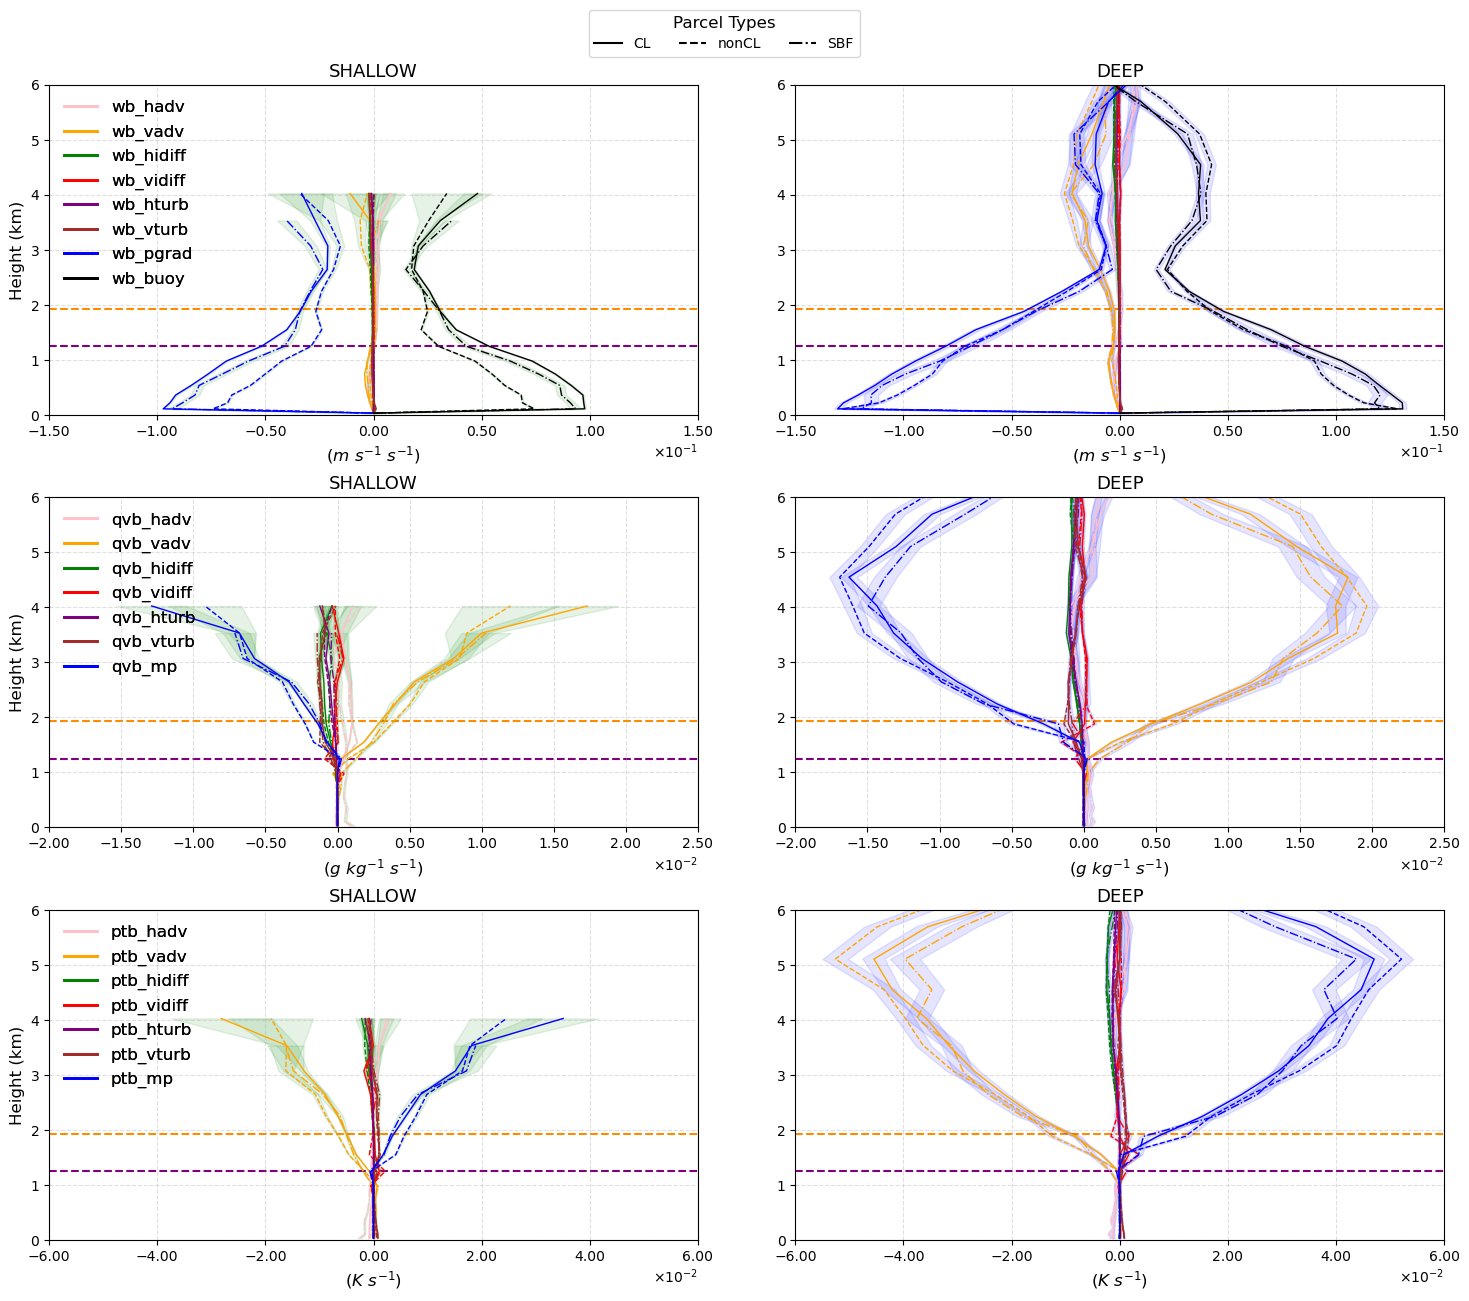

In [47]:
# Group variable names
W_Budgets = ["WB_HADV", "WB_VADV", 
             "WB_HIDIFF","WB_VIDIFF",
             "WB_HTURB", "WB_VTURB", 
             "WB_PGRAD", "WB_BUOY"]

QV_Budgets = ["QVB_HADV", "QVB_VADV",
              "QVB_HIDIFF","QVB_VIDIFF",
              "QVB_HTURB", "QVB_VTURB",
              "QVB_MP"]

TH_Budgets = ["PTB_HADV", "PTB_VADV", 
              "PTB_HIDIFF","PTB_VIDIFF",
              "PTB_HTURB", "PTB_VTURB", 
              "PTB_MP"]

fig = PlotAllVariables(
    profiles_dicts=[trackedProfileArrays_WBudgets,
                    trackedProfileArrays_QVBudgets,
                    trackedProfileArrays_THBudgets],
    profilesSE_dicts=[trackedProfiles_SE_WBudgets,
                      trackedProfiles_SE_QVBudgets,
                      trackedProfiles_SE_THBudgets],
    # profilesSE_dicts=[None,None,None],
    variableGroups=[W_Budgets, QV_Budgets, TH_Budgets],
    variableInfo=variableInfo_Budgets,
    parcelTypes=["CL", "nonCL", "SBF"],
    parcelDepths=["SHALLOW", "DEEP"]
)

#saving
fileName=f"Tracked_Profiles_Budgets" 
SaveFigure(fig,plotType="Project_Algorithms/Tracked_Profiles/Tracked_Profiles_Budgets",fileName=fileName)